In [1]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import classification_report
from tqdm import tqdm
from _posture_detection_model import PostureDetectionModel_LSTM, PostureDetectionModel_GRU, PostureDetectionModel_Dense
from _posture_detection_dataset import PostureDetectionDataset

2023-10-08 12:59:57.180699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 12:59:57.180752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 12:59:57.180798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 12:59:57.192387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
input_channels = 3
channel_sequence_dim = 200
output_class = 5
Model_Name = "posture_detection_model"

Num GPUs Available:  1


2023-10-08 12:59:59.199537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 12:59:59.210369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 12:59:59.210414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
train_dataset = PostureDetectionDataset('data/processed/train/', batch_size=8, shuffle=True)
val_dataset = PostureDetectionDataset('data/processed/valid/', batch_size=2, shuffle=True)
test_dataset = PostureDetectionDataset('data/processed/test/', batch_size=1, shuffle=False)

print("train_dataset:", len(train_dataset))
print("val_dataset:", len(val_dataset))
print("test_dataset:", len(test_dataset))

Found 4240 files in Folder data/processed/train/


100%|██████████| 4240/4240 [00:03<00:00, 1201.91it/s]


Found 530 files in Folder data/processed/valid/


100%|██████████| 530/530 [00:00<00:00, 1226.73it/s]


Found 531 files in Folder data/processed/test/


100%|██████████| 531/531 [00:00<00:00, 865.55it/s] 

train_dataset: 530
val_dataset: 265
test_dataset: 531


In [4]:
data, label, window = train_dataset[100]
print(data.shape)
print(label.shape)
print(window)

(8, 200, 3)
(8, 5)
[490, 3903, 3041, 1951, 4200, 1504, 4585, 3934]


In [5]:
model = PostureDetectionModel_Dense(output_class)

2023-10-08 13:00:03.835748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:00:03.835821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:00:03.835851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:00:04.589222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:00:04.589279: I tensorflow/compile

In [6]:
model.build(input_shape=(None, 200, 3))

In [7]:
model.summary(expand_nested=True)

Model: "posture_detection_model__dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5)                 31685     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 200, 3)]          0        |
|                                                               |
| tf.__operators__.getitem   (None, 200)               0        |
| (SlicingOpLambda)                                             |
|                                                               |
| tf.__operators__.getitem_  (None, 200)               0        |
| 1 (SlicingOpLambda)                                           |
|                                                               |
| tf.__operators__.getitem_  (None, 200)               0        |
| 2 (SlicingOpLambda)                                           |
|                                   

In [8]:
optimizer = keras.optimizers.RMSprop(learning_rate=1e-3)
loss_fn = keras.losses.CategoricalCrossentropy()

In [9]:
def train(optimizer, criterion):
    print("Training the Model...")
    loss_metric = keras.metrics.Mean()
    with tf.device('/device:GPU:0'):
        for step, x_batch_train in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                data, label, window = x_batch_train
                # Forward pass
                output = model(data, training=True)
                # Compute loss
                loss = criterion(label, output)
                loss += sum(model.losses)
                
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

    return loss_metric.result()

def validation(criterion):
    print("Validating the Model...")
    loss_metric = keras.metrics.Mean()
    with tf.device('/device:GPU:0'):
        for step, x_batch_validation in enumerate(val_dataset):
            data, label, window = x_batch_validation
            # Forward pass
            output = model(data, training=False)
            # Compute loss
            loss = criterion(label, output)
            loss += sum(model.losses)
            
            loss_metric(loss)

    return loss_metric.result()

def test():
    print("Testing the Model...")
    
    y_true = []
    y_pred = []

    for step, x_batch_test in enumerate(test_dataset):
        data, label, window = x_batch_test
        # Forward pass
        output = model(data, training=False)
        # Convert to 1 hot encoding
        predicted = tf.argmax(output, axis=1)
        label = tf.argmax(label, axis=1)

        y_true.append(label)
        y_pred.append(predicted)
        
    concat_y_true = tf.concat(y_true, axis=0)
    concat_y_pred = tf.concat(y_pred, axis=0)

    print(classification_report(concat_y_true, concat_y_pred))


In [10]:
epochs = 100

train_losses = []
valid_losses = []

# Iterate over epochs.
for epoch in range(epochs):
    train_loss = train(optimizer, loss_fn)
    train_losses.append(train_loss)

    val_loss = validation(loss_fn)
    valid_losses.append(val_loss)

    print("Epoch %d: train loss = %.4f, val loss = %.4f" % (epoch, train_loss, val_loss))

test()

Training the Model...


2023-10-08 13:00:06.002695: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-08 13:00:06.751435: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5641ed856010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 13:00:06.751479: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-10-08 13:00:06.755357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 13:00:06.890576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 13:00:06.941497: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Validating the Model...
Epoch 0: train loss = 0.9837, val loss = 0.7687
Training the Model...
Validating the Model...
Epoch 1: train loss = 0.7588, val loss = 0.6954
Training the Model...
Validating the Model...
Epoch 2: train loss = 0.7152, val loss = 0.6737
Training the Model...
Validating the Model...
Epoch 3: train loss = 0.6872, val loss = 0.6553
Training the Model...
Validating the Model...
Epoch 4: train loss = 0.6599, val loss = 0.6491
Training the Model...
Validating the Model...
Epoch 5: train loss = 0.6594, val loss = 0.6304
Training the Model...
Validating the Model...
Epoch 6: train loss = 0.6506, val loss = 0.6259
Training the Model...
Validating the Model...
Epoch 7: train loss = 0.6373, val loss = 0.6239
Training the Model...
Validating the Model...
Epoch 8: train loss = 0.6294, val loss = 0.6125
Training the Model...
Validating the Model...
Epoch 9: train loss = 0.6273, val loss = 0.6118
Training the Model...
Validating the Model...
Epoch 10: train loss = 0.6186, val l

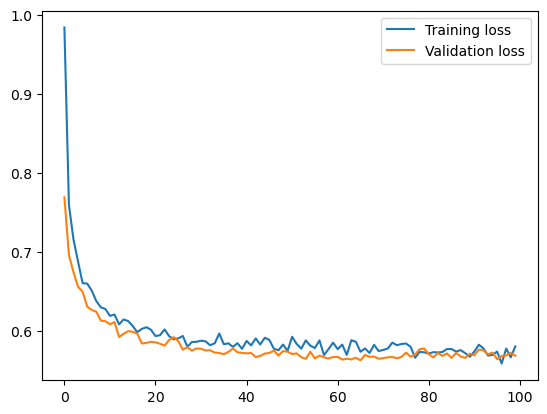

In [11]:
#plotting the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.savefig('losses - relu activated.png')
plt.show()

In [12]:
# Assume 'model' is your trained model
model.save_weights(Model_Name + '.h5')

In [13]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open(Model_Name + '.tflite', 'wb') as f:
  f.write(tflite_model)

2023-10-08 13:32:34.809385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:32:34.809540: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-10-08 13:32:34.809800: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-08 13:32:34.810447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:32:34.810535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-08 13:32:34.810571: I tensor

In [14]:
!xxd -i posture_detection_model.tflite > posture_detection_model.cc